In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

from braket.aws import AwsDevice, AwsQuantumTask
from braket.circuits import Circuit, gates, noises, observables, Gate
from braket.devices import LocalSimulator
from braket.parametric import FreeParameter
import numpy as np
from scipy.stats import unitary_group

Make Circuit

In [4]:
# build a simple circuit
circ = Circuit().h(0).cnot(0,1)

# define a noise channel
noise = noises.BitFlip(probability=0.1)

# add noise to every gate in the circuit
circ.apply_gate_noise(noise)

#noise add

# select the local noise simulator
device = LocalSimulator('braket_dm')

# run the circuit on the local simulator
task = device.run(circ, shots = 1000)

# visualize the results
result = task.result()
measurement = result.measurement_counts
print('measurement results:', measurement)

print('result: ', result)

measurement results: Counter({'00': 424, '11': 398, '01': 96, '10': 82})
result:  GateModelQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='e1e9e8f2-3b21-42d9-80e9-7da2671cc376', shots=1000, deviceId='braket_dm', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), additional_metadata=AdditionalMetadata(action=Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source='OPENQASM 3.0;\nbit[2] b;\nqubit[2] q;\nh q[0];\n#pragma braket noise bit_flip(0.1) q[0]\ncnot q[0], q[1];\n#pragma braket noise bit_flip(0.1) q[0]\n#pragma braket noise bit_flip(0.1) q[1]\nb[0] = measure q[0];\nb[1] = measure q[1];', inputs={}), dwaveMetadata=None, ionqMetadata=None, rigettiMetadata=None, oqcMetadata=None, xanaduMetadata=None, queraMetadata=None, simulatorMetadata=None), result_types=[], values=[], measurements=array([[1, 1],
       [1, 

Questions:
1. what add measurement results mean?
2. 

# Noise Suite


In [22]:
def test_noise_suite(circ, noise_dict, measurements = {}):
    """runs given noise_dict into circ, return measurements

    Args:
        circ (_type_): _description_
        noise_dict (dict): _description_
        measurements (dict, optional): _description_. Defaults to {}.

    Returns:
        dict: measurements
    """
    #state vector run
    measurement = run_circuit(circ, 'braket_sv')
    measurements['braket_sv']=measurement

    for key in noise_dict.keys():
        dynamic_noise_func = getattr(noises, key)
        noise = dynamic_noise_func(noise_dict[key])

        # add noise to every gate in the circuit
        circ.apply_gate_noise(noise)
        measurement = run_circuit(circ, 'braket_dm')
        measurements[key]=measurement
    
    print("Measurements from noise suite")
    for item in measurements.items():
        print(item)

    return measurements

def run_circuit(circ, simulator_type):
    """run circuit with given simulator type

    Args:
        circ (_type_): _description_
        simulator_type (_type_): _description_

    Returns:
        dict: measurement
    """
    # select the local noise simulator
    device = LocalSimulator(simulator_type)

    # run the circuit on the local simulator
    task = device.run(circ, shots = 1000)

    # visualize the results
    result = task.result()
    measurement = result.measurement_counts
    return measurement

def plot_measurements(measurements):
    for key, counts in measurements.items():
        # plot results: see effects of noise
        plt.bar(counts.keys(), counts.values(), label= key)
        plt.title(key)
        plt.xlabel('bitstrings')
        plt.ylabel('counts')
        plt.tight_layout()
        plt.legend()
        plt.savefig(key+'.png', dpi=700)

def benchmark_measurements(measurements):
    """find average difference between state vector counts and noise simulations

    Args:
        measurements (_type_): _description_

    Returns:
        _type_: _description_
    """
    total_difference = 0
    noise_count = len(measurements) - 1
    sv_benchmark = measurements['braket_sv']
    
    for key, counts in measurements.items():
        #print("in measurements for key: ", key, "counts: ", counts)
        if key != 'braket_sv':
            for key_bit, value_count in sv_benchmark.items():
                total_difference += value_count - counts[key_bit]
                #print("total difference: ", total_difference)
    average_difference = total_difference/noise_count
    print("Average difference: ", average_difference)
    return average_difference


## Example usage

In [12]:
# build a simple circuit
circ = Circuit().h(0).cnot(0,1)

noise_dict = {'BitFlip': 0.1, 'PhaseFlip': 0.1, 'Depolarizing': 0.1, 'AmplitudeDamping':0.1, 'PhaseDamping':0.1}
#noise_dict = {'BitFlip': 0.1, 'PhaseFlip': 0.1, 'Depolarizing': 0.1, 'AmplitudeDamping':0.1, 'GeneralizedAmplitudeDamping': [0.1, 0.1], 'PhaseDamping':0.1, 'PauliChannel': [0.1, 0.1, 0.1]}

#using noise suite
measurements = test_noise_suite(circ, noise_dict)


Measurements from noise suite
('braket_sv', Counter({'00': 514, '11': 486}))
('BitFlip', Counter({'00': 399, '11': 399, '10': 109, '01': 93}))
('PhaseFlip', Counter({'11': 425, '00': 397, '10': 95, '01': 83}))
('Depolarizing', Counter({'11': 372, '00': 349, '01': 141, '10': 138}))
('AmplitudeDamping', Counter({'00': 433, '11': 286, '01': 142, '10': 139}))
('PhaseDamping', Counter({'00': 382, '11': 286, '10': 174, '01': 158}))


### Plots
Multi-colours come from cross experiments

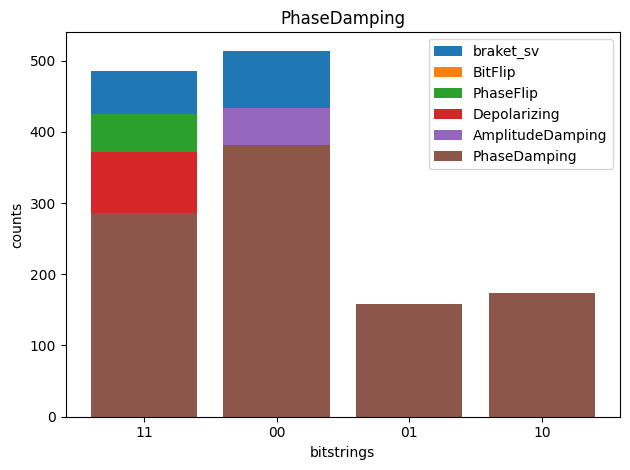

In [23]:
plot_measurements(measurements)

### Average difference between state vector and noise simulation counts.
Lower is better

In [19]:
avg_diff = benchmark_measurements(measurements)


Average difference:  254.4
